### Introduction
Script plots a PCA for the observed data, alongside a PCA using simulated data, utilising the medians of the priors.

### Imports
All imports occur here

In [1]:
import pandas as pd
import sim.model
from sim import sum_stats as ss
import time
import tskit
import msprime
import allel
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Choose parameters
Choose some parameters so it runs relatively quickly:

In [2]:
seq_features = sim.model.SeqFeatures(length=int(20e6), recombination_rate=1.8e-8, mutation_rate=6e-8)

slim_parameters = {
    'pop_size_domestic_1': 1000,  # Population sizes are diploid.
    'pop_size_wild_1': 1000,
    'pop_size_captive': 70,
    'mig_rate_captive': 0.005,  # Migration from wild -> captive
    'mig_length_wild': 20,
    'mig_rate_wild': 0.005,  # Rate of migration from domestic -> wildcats
    'captive_time': 26,  # Time captive population established in SLiM
    }

recapitate_parameters = {
        'pop_size_domestic_2': 2000,
        'pop_size_wild_2': 20000,
        'div_time': 40000,
        'mig_rate_post_split': 0.005,
        'mig_length_post_split': 5000,
        'bottleneck_time_wild': 3000,
        'bottleneck_strength_wild': 20000,
        'bottleneck_time_domestic': 3000,
        'bottleneck_strength_domestic': 20000,
    }

### Run simulation

In [3]:
start_time = time.time()

# Run model
s = sim.model.WildcatSimulation(seq_features=seq_features, random_seed=1)
command = s.slim_command(slim_parameters)
decap_trees = s.run_slim(command)
demographic_events = s.demographic_model(**recapitate_parameters)
tree_seq = s.recapitate(decap_trees, demographic_events)

# Print out useful bits and bobs
print("Simulation finished in {:.2f} s".format(time.time()-start_time))
print("Command ran: {}".format(command))


Simulation finished in 5.91 s
Command ran: slim -d pop_size_domestic_1=1000 -d pop_size_wild_1=1000 -d pop_size_captive=70 -d mig_rate_captive=0.005 -d mig_length_wild=20 -d mig_rate_wild=0.005 -d captive_time=26 -d length=20000000 -d recombination_rate=1.8e-08  -d decap_trees_filename='"../output/decap_1.trees"' -s 40 slim_model.slim


### Sample population

In [4]:
samples = s.sample_nodes(tree_seq, [5, 30, 10])  # Match number of samples to the WGS data
tree_seq = tree_seq.simplify(samples=samples)
data = sim.model.collate_results(tree_seq)

### Calculate summary statistics

In [5]:
one_way_stats = ss.one_way_stats(data)
two_way_stats = ss.two_way_stats(data)

pca_data = ss.pca(pca_genotypes, data.subpops)
pca_one_way_stats = ss.pca_one_way_stats(pca_data)
pca_two_way_stats = ss.pca_two_way_stats(pca_data)

collated_stats = {**one_way_stats, **two_way_stats,
                  **pca_one_way_stats, **pca_two_way_stats}

In [6]:
collated_stats = sim.utils.flatten_dict(collated_stats)

### Plot PCA

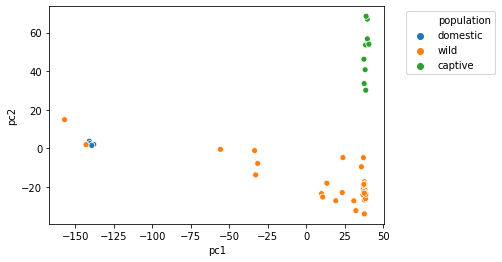

In [6]:
sns.scatterplot(pca_data["pc1"], pca_data["pc2"], hue=pca_data["population"])
plt.legend(bbox_to_anchor=(1.05, 1))

### Check tsinfer ancestral state irrelevant toy example

In [ ]:
import joblib
joblib.dump(np.array(genotypes), "../output/test_genotypes.joblib")
joblib.dump(pos, "../output/test_pos.joblib")

In [ ]:
df = pd.DataFrame({"AB": [1,2,3], "AC": [5,4,5], "CC": [5,7,5]})

In [ ]:
[col for col in list(df) if "A" in col]

In [ ]:
positions = np.loadtxt("../data/e3.012.pos", delimiter="\t", usecols=1)
genotypes = np.loadtxt("../data/e3.012", delimiter="\t", usecols=range(1, len(positions)+1))
genotypes = genotypes.T
assert len(positions) == genotypes.shape[0]

# For now just assume that missings are ancestral
genotypes[genotypes == -1] = 0


In [ ]:
# Cam read in with scikit allel but genotypes looks dodge
callset = allel.read_vcf("../data/e3.vcf")
pos = callset["variants/POS"]
genotypes = allel.GenotypeArray(callset["calldata/GT"])

In [ ]:
callset["samples"][0:3]

In [ ]:
sample_info = pd.read_csv("../data/e3_sample_info.csv", usecols=["NAME", "SOURCE"])

# Ensure that individuals are in same order (after 012 conversion)
assert np.all(sample_info["NAME"] == np.loadtxt("../data/e3.012.indv", dtype=str))

pca_pipeline(genotypes, pos, sample_info["SOURCE"].to_list())

In [ ]:
genotypes, pos = ss.maf_filter(genotypes, pos)
genotypes, pos = ss.ld_prune(genotypes.to_n_alt(), pos)

In [ ]:
plot_ld(genotypes[:1000], 'Pairwise LD after pruning')

### Plot both

In [ ]:
sample_population = np.asarray(["domestic"]*4 + ["wild"]*45 + ["captive"]*46)
populations = ["domestic", "wild", "captive"]
pop_colours = ["#FF0000", "#FFA500", "#0000FF"]

# Simulated data pca
coords, model = allel.pca(genotypes, n_components=10, scaler='patterson')
sim_df = pd.DataFrame({"pc1": coords[:, 0], "pc2": coords[:, 1],
                       "population": sample_population, "simulated_or_observed": "simulated"})

# Real data pca
real_genotypes = np.loadtxt("../data/snps.012", delimiter=" ", skiprows=1)
real_genotypes = real_genotypes[:,1:].transpose()  # Get rid of index and convert individuals to columns
coords, model = allel.pca(real_genotypes, n_components=2, scaler='patterson')
real_df = pd.DataFrame({"pc1": coords[:, 0], "pc2": coords[:, 1],
                   "population": sample_population, "simulated_or_observed": "observed"})

# Combined data
combined_df = sim_df.append(real_df)

In [ ]:
sns.set(style='darkgrid', font_scale=1.3)

g = sns.relplot(x="pc1", y="pc2",
                row="simulated_or_observed", hue="population",
                kind="scatter", data=combined_df,
                facet_kws=dict(sharex=False, sharey=False),
                aspect=1.4)

axes = g.axes.flatten()
axes[0].set_title("Simulated")
axes[1].set_title("Observed")

#g.savefig("../plots/simulated_vs_observed_pca.png", dpi=600)

### Scaling summary statistics

In [7]:
stats = pd.read_csv("../output/summary_stats.csv")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_sum_stats = scaler.fit_transform(stats)
scaler.inverse_transform(scaled_sum_stats)

array([[1.00000000e+00, 1.07623111e-03, 1.36793531e-03, ...,
        4.60612869e+01, 2.92075348e+00, 6.93104553e+01],
       [2.00000000e+00, 1.28440222e-03, 1.55094045e-03, ...,
        2.78705654e+01, 4.34067993e+01, 2.90752602e+01],
       [3.00000000e+00, 1.20031556e-03, 2.47627525e-03, ...,
        4.42130775e+01, 8.47415924e+00, 8.08266296e+01],
       ...,
       [8.25980000e+04, 3.32600000e-04, 2.70985045e-03, ...,
        7.90191507e+00, 2.67198963e+01, 4.16614914e+00],
       [8.25990000e+04, 6.54144444e-04, 3.88075497e-03, ...,
        2.61421089e+01, 1.45125008e+01, 4.52177048e+01],
       [8.26000000e+04, 4.30664444e-04, 1.46628299e-03, ...,
        1.94967823e+01, 1.25374603e+00, 6.43661261e-01]])